# AI-Driven Retail Insights & Power BI Dashboard with Instacart

## 1. Data Understanding & Cleaning
### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")


### 1.2 Load Datasets


In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")

### 1.3 Merge Product Metadata

In [3]:
products_full = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')
products_full.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


### 1.4 Check Missing Values

In [4]:
print("Missing values per dataset:")
print(products_full.isnull().sum())
print(orders.isnull().sum())

Missing values per dataset:
product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


## 2. Exploratory Analysis
### 2.1 Busiest Order Days

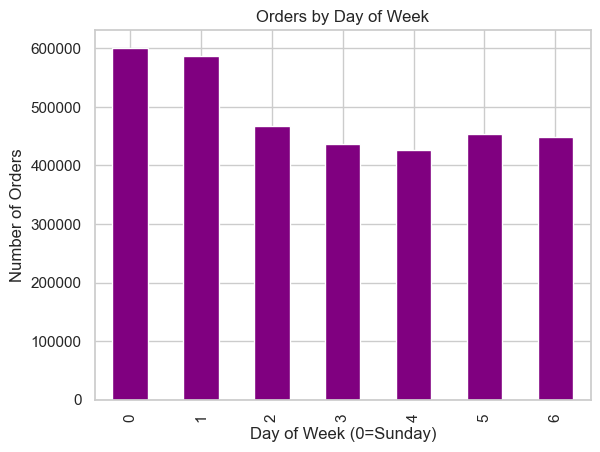

In [5]:
orders['order_dow'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title("Orders by Day of Week")
plt.xlabel("Day of Week (0=Sunday)")
plt.ylabel("Number of Orders")
plt.show()

### 2.2 Busiest Hours

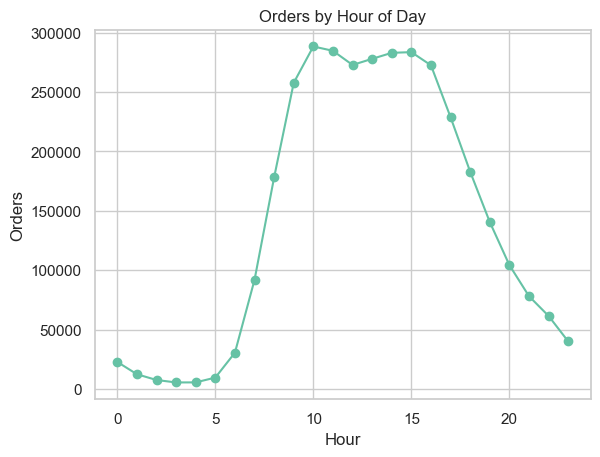

In [6]:
orders['order_hour_of_day'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Orders")
plt.show()

### 2.3 Top Departments

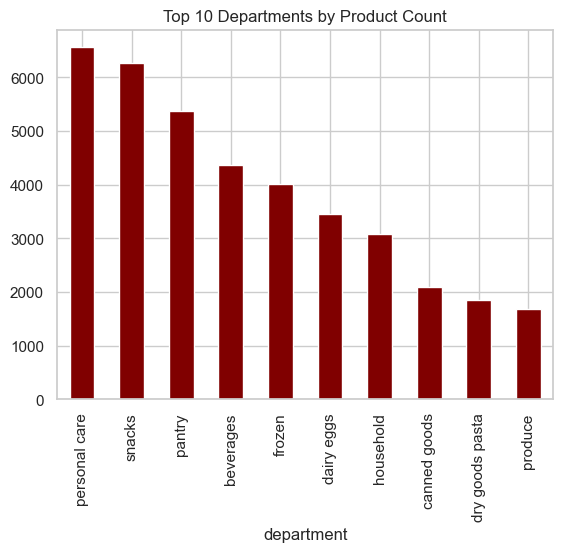

In [7]:
top_departments = products_full['department'].value_counts().head(10)
top_departments.plot(kind='bar', color='maroon')
plt.title("Top 10 Departments by Product Count")
plt.show()

### 2.4 Reorder Ratios

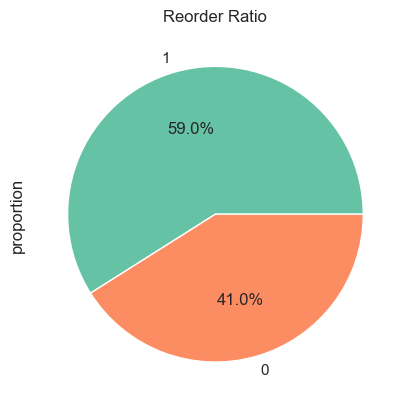

In [8]:
order_products_prior['reordered'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title("Reorder Ratio")
plt.show()

## 3. Customer Segmentation (RFM Analysis)
### 3.1 Prepare RFM Data

In [9]:
rfm = orders.groupby('user_id').agg({
'days_since_prior_order': 'mean',
'order_number': 'max'
}).reset_index()


rfm.rename(columns={'days_since_prior_order':'Recency','order_number':'Frequency'}, inplace=True)


# Monetary = avg basket size
basket_size = order_products_prior.groupby('order_id').size().mean()
rfm['Monetary'] = basket_size
rfm.head()

,user_id,Recency,Frequency,Monetary
0,1,19.000000,11,10.088883
1,2,16.285714,15,10.088883
2,3,12.000000,13,10.088883
3,4,17.000000,6,10.088883
4,5,11.500000,5,10.088883


### 3.2 RFM Segmentation

In [10]:
# Create R, F, M scores 
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method="first"), 5, labels=False) + 1
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=False) + 1
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method="first"), 5, labels=False) + 1

rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].fillna(0).astype(int)

# Calculate final RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

rfm.head()


,user_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1,19.000000,11,10.088883,4,3,1,8
1,2,16.285714,15,10.088883,3,4,1,8
2,3,12.000000,13,10.088883,2,3,1,6
3,4,17.000000,6,10.088883,3,2,1,6
4,5,11.500000,5,10.088883,2,1,1,4


### 3.3 Visualize Segments

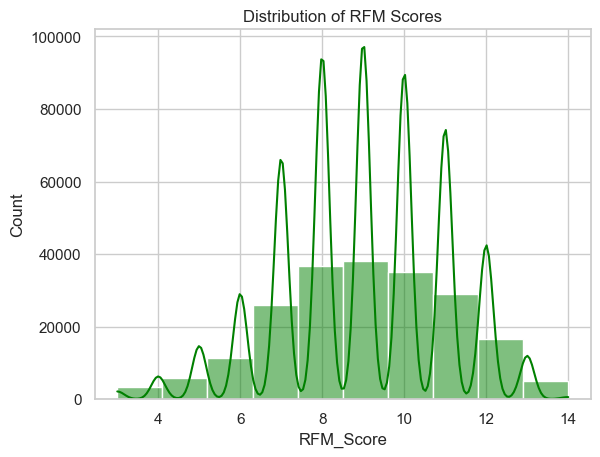

In [11]:
sns.histplot(rfm['RFM_Score'], bins=10, kde=True, color='green')
plt.title("Distribution of RFM Scores")
plt.show()

## 4. Predictive Modeling
### 4.1 Feature Engineering

In [12]:
product_reorder_prob = order_products_prior.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_prob.rename(columns={'reordered':'reorder_prob'}, inplace=True)

### 4.2 Train Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Dummy features: use reorder_prob + frequency
X = product_reorder_prob[['reorder_prob']]
y = (product_reorder_prob['reorder_prob'] > 0.5).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10582
           1       1.00      1.00      1.00      4322

    accuracy                           1.00     14904
   macro avg       1.00      1.00      1.00     14904
weighted avg       1.00      1.00      1.00     14904



## 5. Dashboard + Recommendations
### 5.1 Export for Power BI

In [14]:
import os

os.makedirs("outputs", exist_ok=True)

rfm.to_csv("outputs/user_rfm_segments.csv", index=False)
product_reorder_prob.to_csv("outputs/product_reorder_prob.csv", index=False)

print("✅ Results exported successfully into 'outputs/' folder.")


✅ Results exported successfully into 'outputs/' folder.


### 5.2 Example Recommendation 

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Take a SAMPLE of orders to avoid memory explosion
sample_orders = order_products_prior['order_id'].drop_duplicates().sample(20000, random_state=42)
sample_data = order_products_prior[order_products_prior['order_id'].isin(sample_orders)]

# Convert orders into transaction lists (products per order)
transactions = sample_data.groupby('order_id')['product_id'].apply(list).tolist()

# Encode transactions into one-hot format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori on sample
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Extract association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Show top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


  antecedents consequents  support  confidence      lift
0     (13176)     (21137)  0.01625    0.138889  1.687593
1     (21137)     (13176)  0.01625    0.197448  1.687593
2     (13176)     (21903)  0.01395    0.119231  1.622187
3     (21903)     (13176)  0.01395    0.189796  1.622187
4     (13176)     (27966)  0.01305    0.111538  2.584901
5     (27966)     (13176)  0.01305    0.302433  2.584901
6     (13176)     (47209)  0.01845    0.157692  2.357135
7     (47209)     (13176)  0.01845    0.275785  2.357135
8     (24852)     (16797)  0.01250    0.085675  1.929620
9     (16797)     (24852)  0.01250    0.281532  1.929620


### 5.3 Visualization of Rules

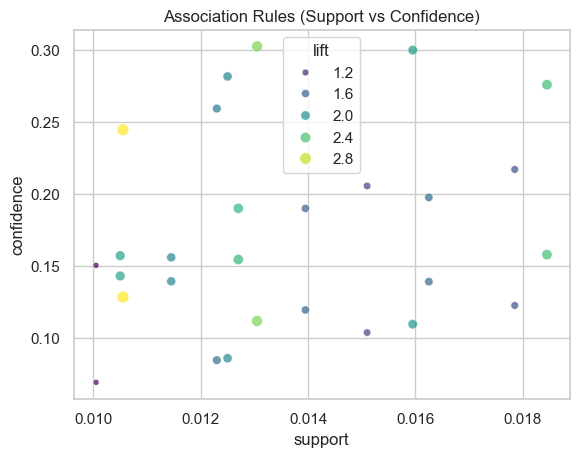

In [16]:
sns.scatterplot(data=rules, x="support", y="confidence", size="lift", hue="lift", alpha=0.7, palette="viridis")
plt.title("Association Rules (Support vs Confidence)")
plt.show()